# Titanic Survival Prediction

## 1.) Introduction

This project will try to predict the likelihood of survival for passengers on the Titanic.

### 1A.) Import Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #Future Warning in front of plots was annoying.
import pandas as pd # Pandas for data frames
import numpy as np # Standard
import seaborn as sns # Data visualization
import matplotlib.pyplot as plt # Plotting
import sklearn # Machine learning library
import sklearn.preprocessing as preprocess # Preprocessing nulls
from scipy import stats #mean, median, mode
from sklearn.metrics import classification_report # Classification report matrix
from sklearn.metrics import roc_curve #ROC curve plotting
from sklearn.model_selection import train_test_split #Splitting training and validation data
from sklearn.linear_model import LogisticRegression #Logistic Regression
from sklearn.ensemble import RandomForestClassifier #Random Forests
from sklearn.neighbors import KNeighborsClassifier #KNearestNeighbors
from sklearn.feature_selection import RFECV
sns.set(style="whitegrid")
sns.set_context(context=None, font_scale=1, rc=None)
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['axes.titlesize']=24

## 2.) Loading Data

In [2]:
titanic = pd.read_csv('train.csv') # Read in training dataset
test = pd.read_csv('test.csv') # Read in testing dataset

# Functions to make life easier

In [3]:
def make_probability_chart(dataframe, target, column):
    """Makes a bar chart showing survival rate by target variable"""
    f, ax = plt.subplots(figsize=(12, 8))
    dataframe.groupby([column])[target].mean().plot(kind='bar')
    plt.title(f'{target} by {column}')
    plt.ylabel(f"Probability of {target}")
    xvals = ax.get_xticks()
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in yvals])
    f.autofmt_xdate()
    plt.show()


# Features Engineered

In [4]:
titanic['Salutation'] = titanic['Name'].str.extract('([A-Za-z]+)\.') 
test['Salutation'] = test['Name'].str.extract('([A-Za-z]+)\.')

titanic['With_family'] = titanic['SibSp'] + titanic['Parch']
test['With_family'] = test['SibSp'] + titanic['Parch']

titanic['Deck'] = titanic['Cabin'].str[0]
test['Deck'] = test['Cabin'].str[0]

titanic['Age'] = titanic.groupby("Salutation")["Age"].transform(lambda x: x.fillna(x.median()))
test['Age'] = test.groupby("Salutation")["Age"].transform(lambda x: x.fillna(x.median()))
test['Age'] = test['Age'].fillna(np.median(test['Age']))

## 3.) Exploratory Data Analysis

### 3A.) First Glance

In [5]:
# First few rows
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,With_family,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,NaN


In [6]:
# Shape of dataset (rows, columns)
titanic.shape

(891, 15)

### 3B.) Survived

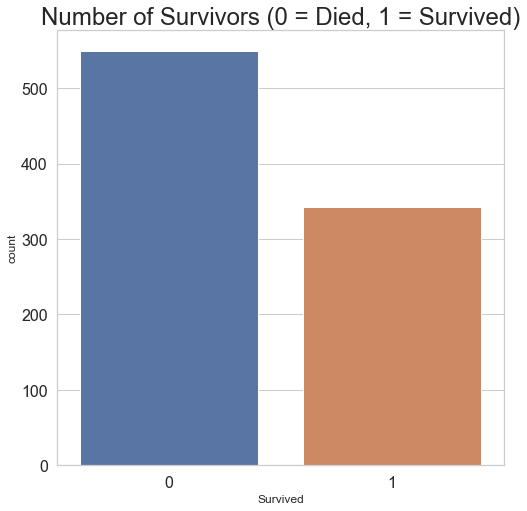

In [7]:
# Create a bar chart showing number of survivors.
f, ax = plt.subplots(figsize=(8, 8))
nsurvivors = sns.countplot(titanic['Survived']).set_title('Number of Survivors (0 = Died, 1 = Survived)')
plt.show()

### 3C.) Passenger Class

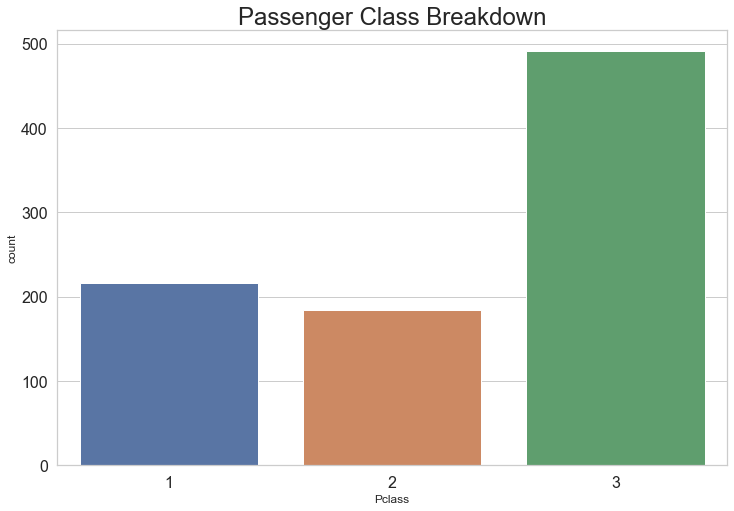

In [8]:
# Updating Color Palatte

plt.subplots(figsize=(12, 8))
sns.countplot(titanic['Pclass']).set_title('Passenger Class Breakdown')
plt.show()


C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


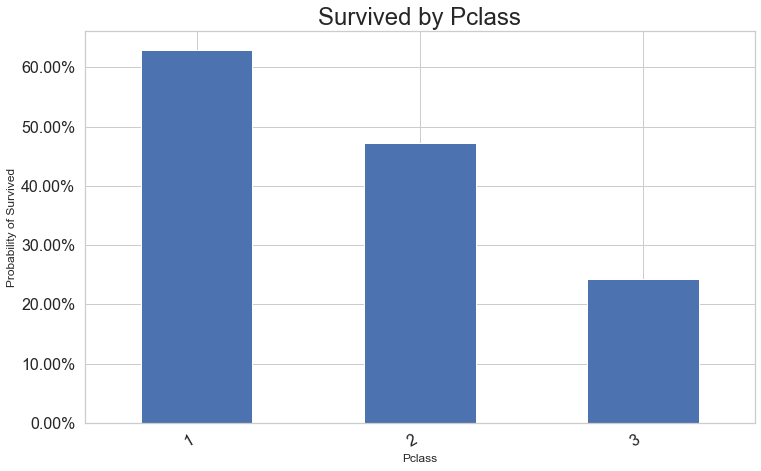

In [9]:
make_probability_chart(titanic, "Survived", "Pclass")

### 3D.) Name

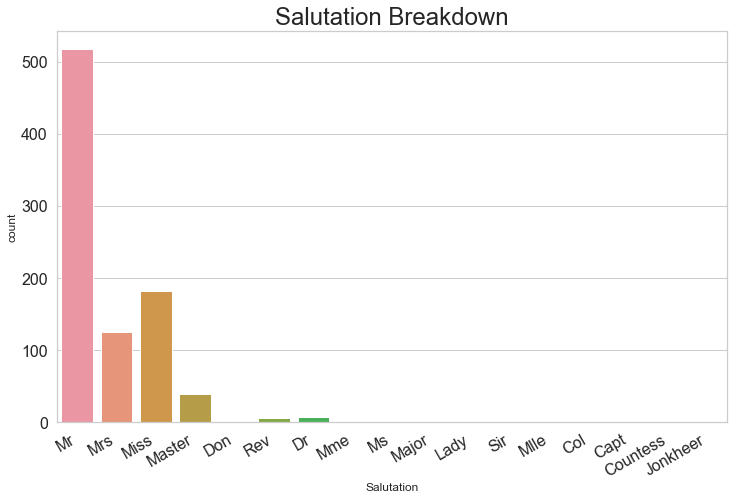

In [10]:
f, ax = plt.subplots(figsize=(12, 8))
sns.countplot(titanic['Salutation']).set_title('Salutation Breakdown')
f.autofmt_xdate()
plt.show()



C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


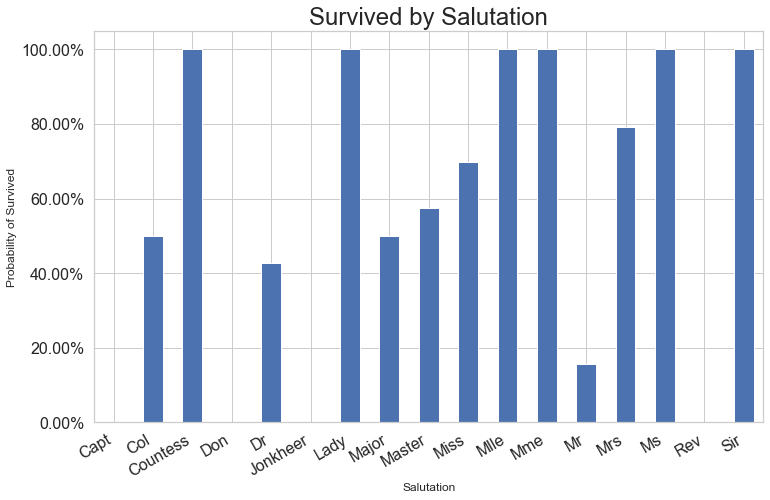

In [11]:
make_probability_chart(titanic, "Survived", "Salutation")

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


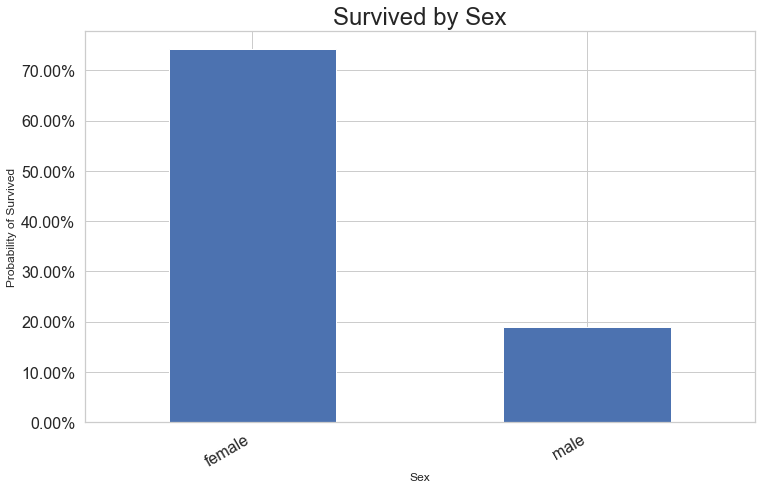

In [12]:
make_probability_chart(titanic, "Survived", "Sex")

### 3F.) Age

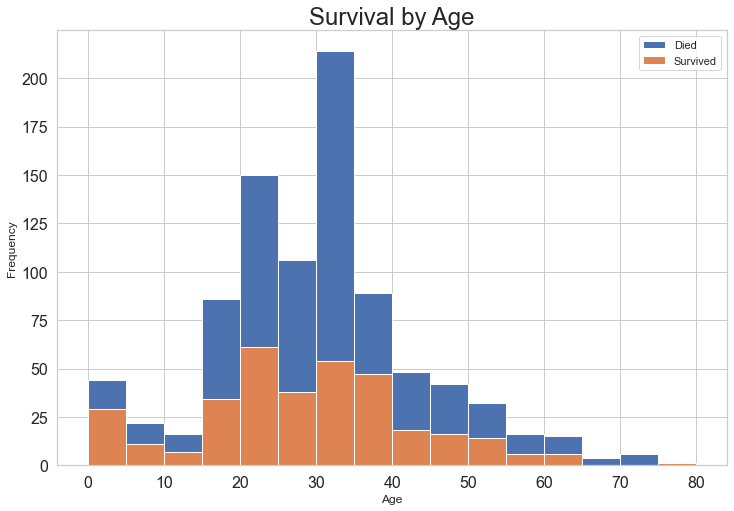

In [13]:
# Create a stacked histogram to show survival by age.
f, ax = plt.subplots(figsize=(12, 8))
titanic['Age'].plot.hist(bins=range(0, 85, 5))
age_plot = titanic[titanic['Survived'] == 1]['Age'].plot.hist(bins=range(0, 85, 5))
age_plot.legend(['Died', 'Survived'])
age_plot.set_title('Survival by Age')
age_plot.set_xlabel('Age')
plt.show()


### 3G.) Family

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


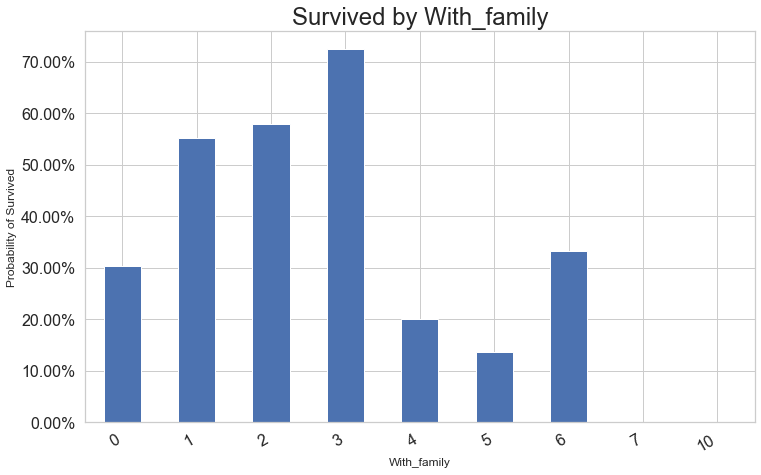

In [14]:
# Combining siblings and parents into family

make_probability_chart(titanic, "Survived", "With_family")

### 3H.) Cabin

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


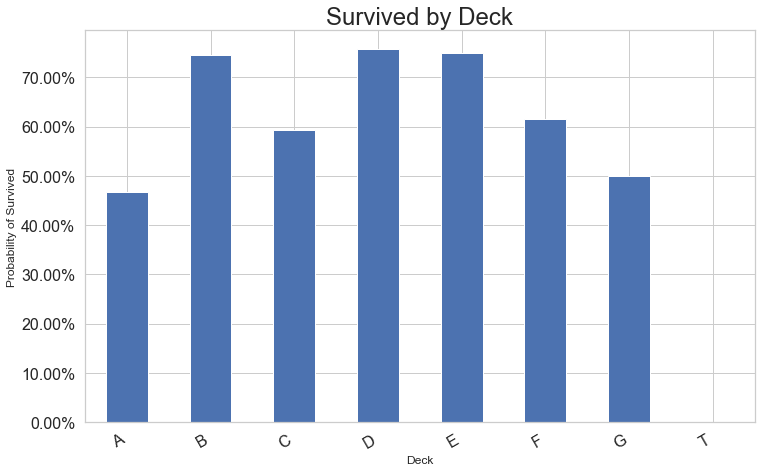

In [15]:
# Replaced cabins with a deck. NaNs for level have 'n'. 
make_probability_chart(titanic, "Survived", "Deck")

### 3I.) Fare

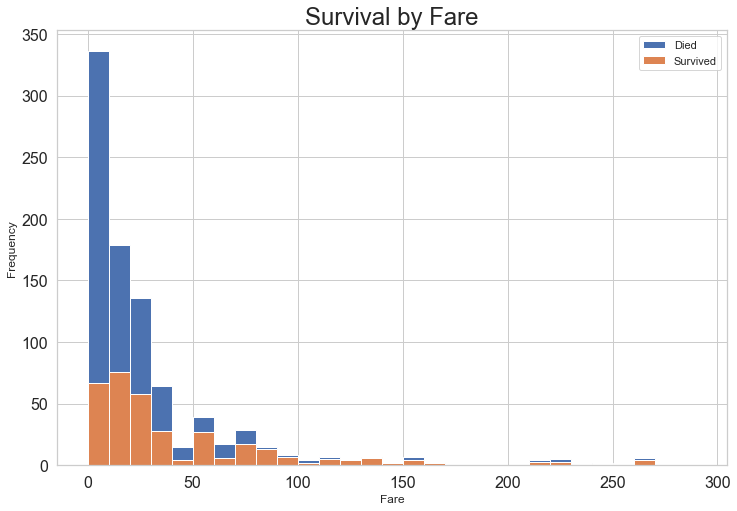

In [16]:
# Create a stacked histogram to show survival by age.
f, ax = plt.subplots(figsize=(12, 8))
titanic['Fare'].plot.hist(bins=range(0, 300, 10))
age_plot = titanic[titanic['Survived'] == 1]['Fare'].plot.hist(bins=range(0, 300, 10))
age_plot.legend(['Died', 'Survived'])
age_plot.set_title('Survival by Fare')
age_plot.set_xlabel('Fare')
plt.show()

### 3J.) Embarked

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


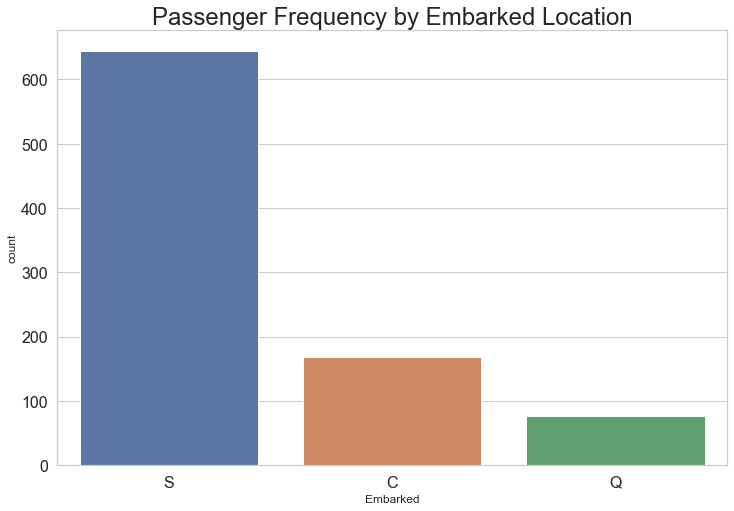

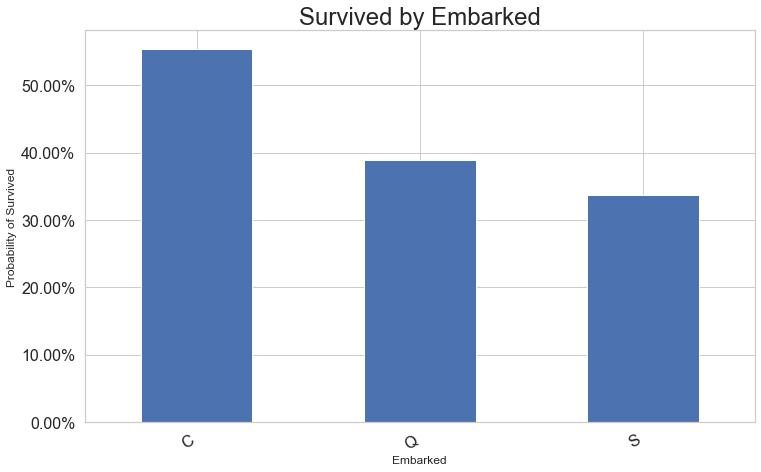

In [17]:
f, ax = plt.subplots(figsize=(12, 8))
sns.countplot(titanic['Embarked']).set_title('Passenger Frequency by Embarked Location')
make_probability_chart(titanic, "Survived", "Embarked")


## 4.) Filling in Missing Values

### 4A.) Figure out what is missing

In [18]:
print("Training Data")
print(titanic.isnull().sum())
print('\n')
print("Testing Data")
print(test.isnull().sum())

Training Data
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Salutation       0
With_family      0
Deck           687
dtype: int64


Testing Data
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              1
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Salutation       0
With_family      0
Deck           327
dtype: int64


### 4B.) Age

In [19]:
age_by_salutation = titanic.groupby('Salutation')['Age'].median()

In [20]:
titanic['Age'] = titanic.groupby("Salutation")["Age"].transform(lambda x: x.fillna(x.median()))
test['Age'] = titanic.groupby("Salutation")["Age"].transform(lambda x: x.fillna(x.median()))

### 4C.) Deck

In [21]:
# Replaced cabins with a cabin level. NaNs for level have 'n'. 
titanic['Deck'] = titanic['Deck'].fillna('N')
test['Deck'] = test['Deck'].fillna('N')

# There is no deck 'T' on the Titanic, so replacing that with 'N':
titanic[titanic['Deck'] == 'T'] = titanic[titanic['Deck'] == 'T'].replace('T', 'N')
test[test['Deck'] == 'T'] = test[test['Deck'] == 'T'].replace('T', 'N')

### 4D.) Fare

In [22]:
# Fill the one NA in test with the fare median
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

### 4E.) Embarked

In [23]:
# According to Encyclopedia Titanica, both of the null passengers embarked at Southampton. 
# https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html
titanic[titanic['Embarked'].isnull()] = titanic[titanic['Embarked'].isnull()].fillna('S')

### 4F.) Sanity Check

In [24]:
# Sanity check to make sure all missing values are taken care of. Cabin won't be in any of the models, so we're good.
titanic.isnull().sum()
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Salutation       0
With_family      0
Deck             0
dtype: int64

In [25]:
test[test['Age'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,With_family,Deck


In [26]:
# Sanity check to make sure all missing values are taken care of. Cabin won't be in any of the models, so we're good.
titanic.isnull().sum()
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Salutation       0
With_family      0
Deck             0
dtype: int64

## 5.) Model Preparations

### 5A.) Drop Columns

In [27]:
top_four = titanic['Salutation'].value_counts().nlargest(4).index
titanic['Salutation'] = titanic['Salutation'].where(titanic['Salutation'].isin(top_four), other="Other")
test['Salutation'] = titanic['Salutation'].where(test['Salutation'].isin(top_four), other="Other")

In [28]:
# Dropping columns not needed in the model. Took out Salutation because of dimension mismatches between training and test.
X_train = titanic.drop(['Survived', 'PassengerId', 'Name', 'SibSp', 'Parch', 'Cabin', 'Ticket'], 1) # 1 is to specify columns
y_train = titanic['Survived']
X_test = test.drop(['PassengerId', 'Cabin', 'Name', 'SibSp', 'Parch', 'Ticket'], 1)

### 5B.) Add Dummy Variables

In [29]:
# Fit and transform categorical variables to integers
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [30]:
X_test

,Pclass,Age,Fare,With_family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Salutation_Master,...,Salutation_Mrs,Salutation_Other,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_N
0,3,22.0,7.8292,0.0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3,38.0,7.0000,1.0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,2,26.0,9.6875,0.0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,35.0,8.6625,0.0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4,3,35.0,12.2875,1.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,30.0,8.0500,0.0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
414,1,44.0,108.9000,0.0,1,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
415,3,35.0,7.2500,0.0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
416,3,34.0,8.0500,1.0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


### 5C.) Normalize Data

In [31]:
# Normalizing age, fare, with_family columns
X_train['Fare'] = stats.zscore(X_train['Fare'])
X_train['Age'] = stats.zscore(X_train['Age'])
X_train['With_family'] = stats.zscore(X_train['With_family'])
X_test['Fare'] = stats.zscore(X_test['Fare'])
X_test['Age'] = stats.zscore(X_test['Age'])
X_test['With_family'] = stats.zscore(X_test['With_family'])

### 5D.) Split Titanic Data into Training and Validation Model

In [32]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(712, 22)
(179, 22)
(418, 22)


## 6.) Modeling and Verifying Model

### 6A.) Logistic Regression

In [33]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_validation)
print(classification_report(y_validation, y_pred_log))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_validation)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       106
           1       0.79      0.74      0.77        73

   micro avg       0.82      0.82      0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179



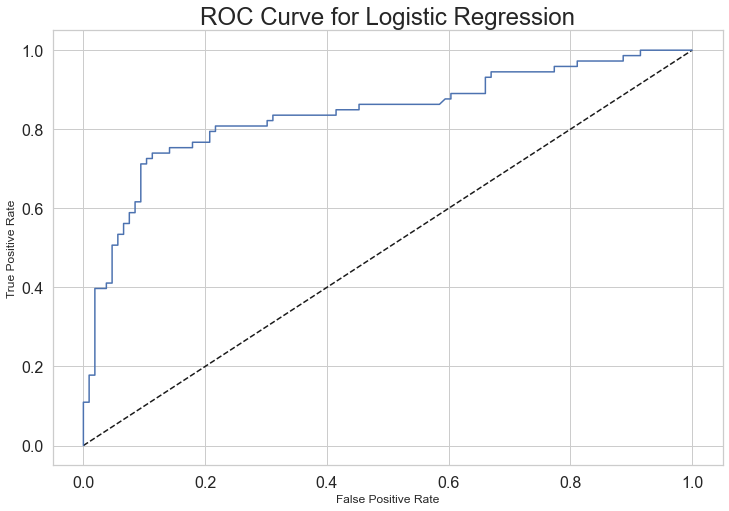

In [34]:
# Plot ROC curve
f, ax = plt.subplots(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.show()

Optimal number of features: 12
Selected features: ['Pclass', 'With_family', 'Sex_female', 'Embarked_C', 'Salutation_Master', 'Salutation_Mr', 'Salutation_Mrs', 'Salutation_Other', 'Deck_B', 'Deck_D', 'Deck_E', 'Deck_N']


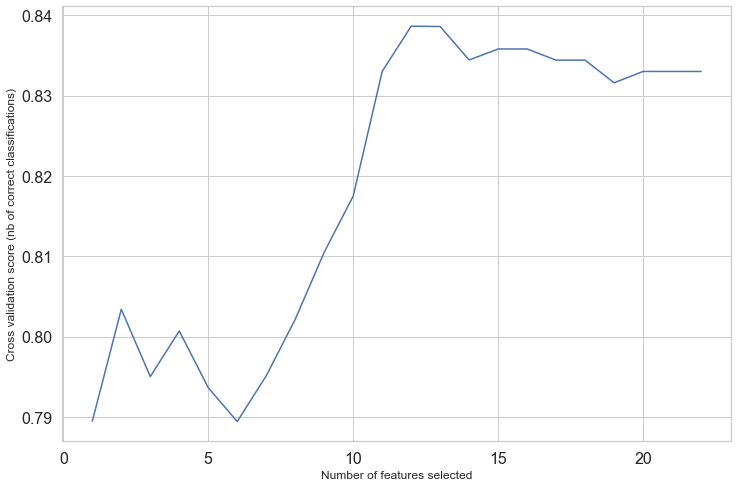

In [35]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X_train.columns[rfecv.support_]))

plt.figure(figsize=(12,8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


### 6B.) Random Forest

In [36]:
random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_validation)
print(classification_report(y_validation, y_pred_rf))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = random_forest.predict_proba(X_validation)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)


              precision    recall  f1-score   support

           0       0.77      0.87      0.81       106
           1       0.76      0.62      0.68        73

   micro avg       0.77      0.77      0.77       179
   macro avg       0.76      0.74      0.75       179
weighted avg       0.77      0.77      0.76       179



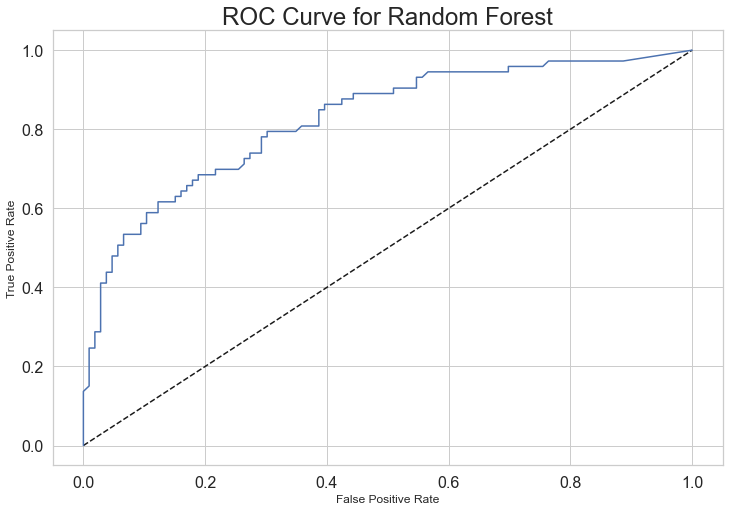

In [37]:

plt.figure(figsize=(12,8))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.show()

In [38]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

# Create the parameter grid
param_grid = {'n_estimators': [1000],
              'max_depth': [x for x in range(3, 10)]}

gridsearch = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1, 
                                verbose=5, return_train_score=True, cv=5)

y_pred_gridsearch = gridsearch.fit(X_train, y_train).predict(X_validation)
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)
print(classification_report(y_validation, y_pred_gridsearch))

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   29.0s finished


              precision    recall  f1-score   support

           0       0.78      0.92      0.84       106
           1       0.84      0.63      0.72        73

   micro avg       0.80      0.80      0.80       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179



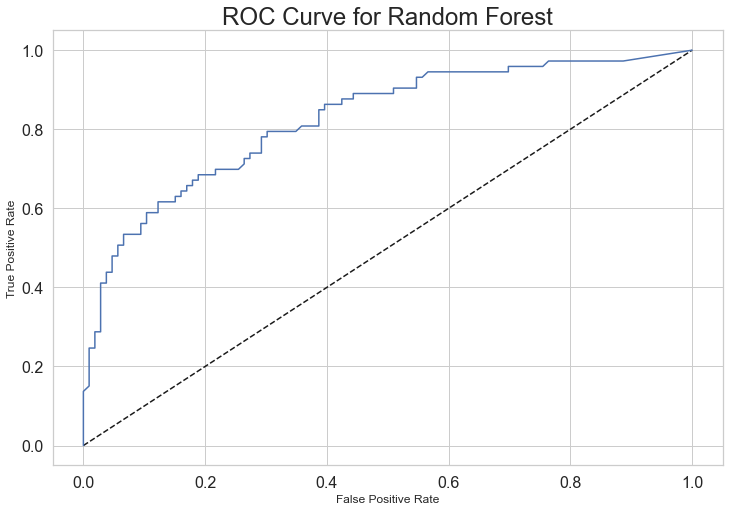

In [39]:
y_pred_prob = gridsearch.predict_proba(X_validation)[:,1]
plt.figure(figsize=(12,8))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.show()

### 6C.) K-Nearest Neighbors 

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       106
           1       0.82      0.63      0.71        73

   micro avg       0.79      0.79      0.79       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.79      0.79       179



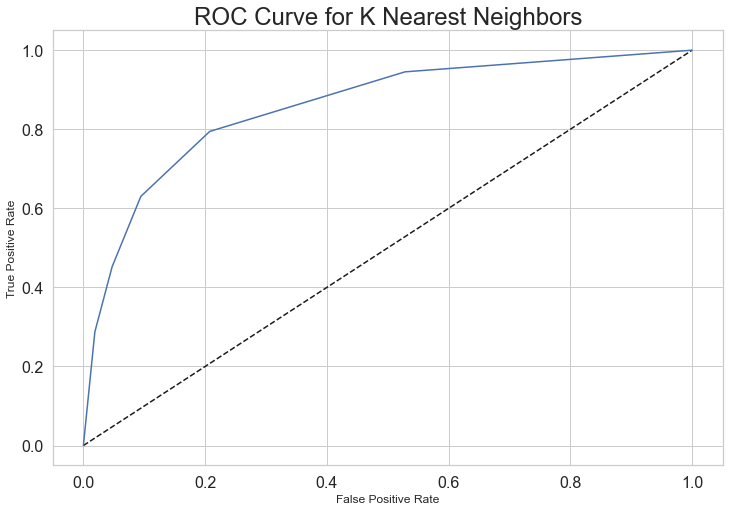

In [40]:
# Create kNN model
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_validation)
print(classification_report(y_validation, y_pred_knn))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = knn.predict_proba(X_validation)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(12,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for K Nearest Neighbors')
plt.show()

## 7.) Conclusion

In [41]:
y_predict1 = rfecv.predict(X_test)
y_predict2 = gridsearch.predict(X_test)
y_predict3 = knn.predict(X_test)

predictions_df = pd.DataFrame([X_test.index, y_predict1, y_predict2, y_predict3]).transpose()
columns=["PassengerId", "Logistic", "RF", "KNN"]
predictions_df.columns = columns
predictions_df.set_index(test['PassengerId'], inplace=True)
predictions_df['Survived'] = round((predictions_df['Logistic'] + predictions_df['RF'] + predictions_df['KNN']) / 3).astype('int')
predictions_df

,PassengerId,Logistic,RF,KNN,Survived
PassengerId,,,,,
892,0,0,0,0,0
893,1,1,0,1,1
894,2,0,0,0,0
895,3,0,0,0,0
896,4,0,0,1,0
...,...,...,...,...,...
1305,413,0,0,0,0
1306,414,1,1,1,1
1307,415,0,0,0,0


In [42]:
# 8B.) Write dataframe to CSV
Submission = predictions_df['Survived']
Submission.to_csv("Submission.csv")
# Submission to Kaggle was using a "weighted voting" system with all three models receiving a vote.